# Data set interpolation each file 

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import os
from workalendar.europe import Germany
from datetime import date, timedelta
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
import pvlib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")



In [4]:
# using interpolation 

input_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\Dataset'
output_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\InterpolatedData/'

os.makedirs(output_directory, exist_ok=True)

for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):
        input_filepath = os.path.join(input_directory, filename)
        
        df = pd.read_csv(input_filepath, parse_dates=['timestampUtc'], index_col='timestampUtc')
        
        df_interpolated = df.interpolate(method='cubic', limit_direction='both')
        
        for col in df_interpolated:
            max_val_before = df[col].max()
            min_val_before = df[col].min()
            df_interpolated[col] = df_interpolated[col].clip(upper=max_val_before, lower=min_val_before)
        
        output_filepath = os.path.join(output_directory, filename)
        df_interpolated.to_csv(output_filepath)

print("Interpolation and clipping completed. Files saved to:", output_directory)


Interpolation and clipping completed. Files saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\InterpolatedData/


# Scalling

In [5]:

input_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\InterpolatedData/'

output_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/'

for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):   
        input_file_path = os.path.join(input_directory, filename)
        
        data = pd.read_csv(input_file_path)
        
        timestampUtc = data['timestampUtc']
        X = data.drop(['timestampUtc', 'value'], axis=1)
        y = data['value']

        X_scaler = StandardScaler()
        scaled_X = X_scaler.fit_transform(X)

        y_scaler = StandardScaler()
        scaled_y = y_scaler.fit_transform(y.values.reshape(-1, 1))  
        
        scaled_data = pd.DataFrame(scaled_X, columns=X.columns)
        scaled_data['value'] = scaled_y.flatten()  
        scaled_data['timestampUtc'] = timestampUtc  

        output_file_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}.csv")
        scaled_data.to_csv(output_file_path, index=False)

        print(f'Scaled data saved to: {output_file_path}')


Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/pv_1.csv
Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/pv_10.csv
Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/pv_11.csv
Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/pv_12.csv
Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/pv_13.csv
Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/pv_14.csv
Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/pv_15.csv
Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/pv_16.csv
Scaled data saved to: E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Fil

# Outliers Removal

In [6]:

input_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Data_Scaled/'
output_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\OutliersRemoved/'

os.makedirs(output_directory, exist_ok=True)

data_frames = []

for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):
        input_filepath = os.path.join(input_directory, filename)
        output_filepath = os.path.join(output_directory, filename)
        df = pd.read_csv(input_filepath, parse_dates=['timestampUtc'], index_col='timestampUtc')
        
        z = np.abs(stats.zscore(df[df.select_dtypes(include=[np.number]).columns]))
        df_no_outliers = df.mask((z > 3))
        
        df_no_outliers.to_csv(output_filepath)

## Adding seasonal components in each file 

In [7]:

input_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\OutliersRemoved/'
output_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\SeasonalComponentsAdded/'

os.makedirs(output_directory, exist_ok=True)

for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):
        input_filepath = os.path.join(input_directory, filename)
        output_filepath = os.path.join(output_directory, filename)
        df = pd.read_csv(input_filepath, parse_dates=['timestampUtc'], index_col='timestampUtc')
        
        df.ffill(inplace=True)
        
        result = seasonal_decompose(df['value'], model='additive', period=7)
        
        df['seasonal_trend'] = result.trend
        df['seasonal_seasonal'] = result.seasonal
        df['seasonal_residuals'] = result.resid
        
        df.to_csv(output_filepath)


# Longitude & Latitude

In [8]:

input_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\SeasonalComponentsAdded/'
output_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Longitude&LatitudeAdded/'

latitude = 48.7758  
longitude = 9.1829  
os.makedirs(output_directory, exist_ok=True)

file_list = [f for f in os.listdir(input_directory) if f.endswith('.csv')]

for filename in file_list:
    input_filepath = os.path.join(input_directory, filename)
    output_filepath = os.path.join(output_directory, filename)

    df = pd.read_csv(input_filepath, parse_dates=['timestampUtc'], index_col='timestampUtc')

    solar_position = pvlib.solarposition.get_solarposition(df.index, latitude=latitude, longitude=longitude)

    df['solar_zenith'] = solar_position['apparent_zenith']
    df['solar_azimuth'] = solar_position['azimuth']

    df.to_csv(output_filepath)


# Holidays

In [9]:
germany_calendar = Germany()
start_year = 2019
end_year = 2023

holidays_df = pd.DataFrame(columns=['date', 'holiday_name'])

for year in range(start_year, end_year + 1):
    holidays = germany_calendar.holidays(year)
    year_holidays_df = pd.DataFrame(holidays, columns=['date', 'holiday_name'])
    holidays_df = pd.concat([holidays_df, year_holidays_df], ignore_index=True)

current_date = date(start_year, 1, 1)
end_date = date(end_year, 12, 31)

weekend_data = []

while current_date <= end_date:
    if current_date.weekday() in [5, 6]:  # 5 is Saturday, 6 is Sunday
        weekend_data.append({'date': current_date, 'holiday_name': 'Weekend'})
    current_date += timedelta(days=1)

weekend_df = pd.DataFrame(weekend_data)

holidays_df = pd.concat([holidays_df, weekend_df], ignore_index=True)

holidays_df = holidays_df.sort_values(by='date')


In [10]:

input_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\Longitude&LatitudeAdded'  
output_directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\HolidaysAdded'   
os.makedirs(output_directory, exist_ok=True)

file_list = [f for f in os.listdir(input_directory) if f.endswith('.csv')]

for filename in file_list:
    input_filepath = os.path.join(input_directory, filename)
    output_filepath = os.path.join(output_directory, filename)

    df = pd.read_csv(input_filepath)
    df["timestamp"] = pd.to_datetime(df["timestampUtc"])
    df = df.drop(columns=["timestampUtc"]).set_index("timestamp")

    df['Day_value_Stamp'] = df.index.hour * 4 + df.index.minute / 15

    df['day_of_week'] = df.index.dayofweek

    data_dates = pd.to_datetime(df.index.date)

    df['Holidays'] = data_dates.isin(holidays_df['date']).astype(np.int8)
    pd.reset_option('display.max_rows')
    print(df)

    df.to_csv(output_filepath)


                              t_2mc  aswdifd_s  aswdir_s  vmax_10m  tot_prec  \
timestamp                                                                      
2021-10-01 00:00:00+00:00 -0.610846  -0.736361  -0.50234 -1.109262  -0.12226   
2021-10-01 00:15:00+00:00 -0.610846  -0.736361  -0.50234 -1.109262  -0.12226   
2021-10-01 00:30:00+00:00 -0.610846  -0.736361  -0.50234 -1.109262  -0.12226   
2021-10-01 00:45:00+00:00 -0.610846  -0.736361  -0.50234 -1.109262  -0.12226   
2021-10-01 01:00:00+00:00 -0.663283  -0.736361  -0.50234 -1.130614  -0.12226   
...                             ...        ...       ...       ...       ...   
2023-09-30 23:00:00+00:00 -0.145813  -0.736361  -0.50234 -0.869926  -0.12226   
2023-09-30 23:15:00+00:00 -0.145813  -0.736361  -0.50234 -0.869926  -0.12226   
2023-09-30 23:30:00+00:00 -0.145813  -0.736361  -0.50234 -0.869926  -0.12226   
2023-09-30 23:45:00+00:00 -0.145813  -0.736361  -0.50234 -0.869926  -0.12226   
2023-10-01 00:00:00+00:00 -0.201544  -0.

In [11]:
holidays_df.head

<bound method NDFrame.head of            date          holiday_name
0    2019-01-01              New year
45   2019-01-05               Weekend
46   2019-01-06               Weekend
47   2019-01-12               Weekend
48   2019-01-13               Weekend
..          ...                   ...
564  2023-12-24               Weekend
43   2023-12-25         Christmas Day
44   2023-12-26  Second Christmas Day
565  2023-12-30               Weekend
566  2023-12-31               Weekend

[567 rows x 2 columns]>

# Concat & Save file 

In [12]:

directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\HolidaysAdded'

data_frames = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)

        try:
            df = pd.read_csv(filepath, parse_dates=True, index_col='timestamputc')
        except ValueError:
            df = pd.read_csv(filepath, parse_dates=True)

        data_frames.append(df)

combined_data = pd.concat(data_frames, axis=0)


In [13]:

directory = 'E:\TH-Koeln University\Semester 3\Hyperparameter tuning\VS_Code_Files\HolidaysAdded'
data_frames = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        data_frames.append(df)

combined_data_ydm = pd.concat(data_frames, axis=0, ignore_index=True)


In [14]:
import pandas as pd

combined_data_ydm['timestamp'] = pd.to_datetime(combined_data_ydm['timestamp'])

combined_data_ydm['year'] = combined_data_ydm['timestamp'].dt.year
combined_data_ydm['month'] = combined_data_ydm['timestamp'].dt.month
combined_data_ydm['day'] = combined_data_ydm['timestamp'].dt.day

combined_data_ydm = combined_data_ydm.drop('timestamp', axis=1)

In [15]:
combined_data_ydm.columns

Index(['t_2mc', 'aswdifd_s', 'aswdir_s', 'vmax_10m', 'tot_prec', 'value',
       'seasonal_trend', 'seasonal_seasonal', 'seasonal_residuals',
       'solar_zenith', 'solar_azimuth', 'Day_value_Stamp', 'day_of_week',
       'Holidays', 'year', 'month', 'day'],
      dtype='object')

In [ ]:
combined_data_ydm = combined_data.ffill()
combined_data_ydm.to_csv('./combined_data.csv')

# Optuna for hyperparameter tuning 
###### https://www.kaggle.com/code/bextuychiev/lgbm-optuna-hyperparameter-tuning-w-understanding

In [7]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

X = combined_data_ydm.drop('value', axis=1)  
y = combined_data_ydm['value']   

tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    mse_scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        params = {
            "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 100, step=20),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
            # "max_bin": trial.suggest_int("max_bin", 200, 300),
            # "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
            # "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
            # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
            # "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
            # "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
            # "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
            }

        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

        model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_valid])

        predictions = model.predict(X_val)

        mse = mean_squared_error(y_val, predictions)
        mse_scores.append(mse)

    return sum(mse_scores) / len(mse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

best_params = study.best_params
print(f'Best Hyperparameters: {best_params}')

#final_model = lgb.LGBMRegressor(**best_params)
#final_model.fit(X, y)


[I 2023-12-12 12:17:34,024] A new study created in memory with name: no-name-671c776e-1e7e-4882-9bce-d7b3bf9b2a5e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2492
[LightGBM] [Info] Number of data points in the train set: 398694, number of used features: 16
[LightGBM] [Info] Start training from score 0.026625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 797385, number of used features: 16
[LightGBM] [Info] Start training from score 0.014385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2023-12-12 13:42:29,906] Trial 0 finished with value: 0.000618098775361869 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07495532054501908, 'num_leaves': 20, 'max_depth': 8}. Best is trial 0 with value: 0.000618098775361869.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2492
[LightGBM] [Info] Number of data points in the train set: 398694, number of used features: 16
[LightGBM] [Info] Start training from score 0.026625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 797385, number of used features: 16
[LightGBM] [Info] Start training from score 0.014385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 1196076, number of used features: 16
[LightGBM] [Info] Start

[I 2023-12-12 15:16:38,224] Trial 1 finished with value: 0.0006698451607781585 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25519808583226666, 'num_leaves': 40, 'max_depth': 9}. Best is trial 0 with value: 0.000618098775361869.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2492
[LightGBM] [Info] Number of data points in the train set: 398694, number of used features: 16
[LightGBM] [Info] Start training from score 0.026625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[W 2023-12-12 16:09:27,411] Trial 2 failed with parameters: {'n_estimators': 10000, 'learning_rate': 0.11153591176104888, 'num_leaves': 100, 'max_depth': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Muhammad Ali\anaconda3\envs\enbw\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Muhammad Ali\AppData\Local\Temp\ipykernel_15596\3608081243.py", line 38, in objective
    predictions = model.predict(X_val)
  File "c:\Users\Muhammad Ali\anaconda3\envs\enbw\lib\site-packages\lightgbm\basic.py", line 4220, in predict
    return predictor.predict(
  File "c:\Users\Muhammad Ali\anaconda3\envs\enbw\lib\site-packages\lightgbm\basic.py", line 1047, in predict
    preds, nrow = self.__pred_for_np2d(
  File "c:\Users\Muhammad Ali\anaconda3\envs\enbw\lib\site-packages\lightgbm\basic.py", line 1187, in __pred_for_np2d
    return self.__inner_predict_np2d(
  File "c:\Us

KeyboardInterrupt: 

# lgb Dataloader and cross validation 

In [15]:

tscv = TimeSeriesSplit(n_splits=5)  
for train_index, test_index in tscv.split(combined_data):
    train_data, test_data = combined_data.iloc[train_index], combined_data.iloc[test_index]

    lgb_train = lgb.Dataset(train_data[['value', 't_2mc', 'aswdifd_s', 'aswdir_s', 'vmax_10m', 'tot_prec','seasonal_trend', 'seasonal_seasonal', 'seasonal_residuals', 'solar_zenith', 'solar_azimuth']],
                            label=train_data['value'], feature_name=['value', 't_2mc', 'aswdifd_s', 'aswdir_s', 'vmax_10m', 'tot_prec','seasonal_trend', 'seasonal_seasonal', 'seasonal_residuals', 'solar_zenith', 'solar_azimuth'],
                            )   
    lgb_valid = lgb.Dataset(test_data[['value', 't_2mc', 'aswdifd_s', 'aswdir_s', 'vmax_10m', 'tot_prec','seasonal_trend', 'seasonal_seasonal', 'seasonal_residuals', 'solar_zenith', 'solar_azimuth']],
                            label=test_data['value'], reference=lgb_train, feature_name=['value', 't_2mc', 'aswdifd_s', 'aswdir_s', 'vmax_10m', 'tot_prec','seasonal_trend', 'seasonal_seasonal', 'seasonal_residuals', 'solar_zenith', 'solar_azimuth'],
                            ) 

    params = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }


    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=10,
                      valid_sets=[lgb_train, lgb_valid],
                      #early_stopping_round =10,
                      #verbose_eval=10
                      )

   
    predictions = model.predict(test_data[['value', 't_2mc', 'aswdifd_s', 'aswdir_s', 'vmax_10m', 'tot_prec','seasonal_trend', 'seasonal_seasonal', 'seasonal_residuals', 'solar_zenith', 'solar_azimuth']], num_iteration=model.best_iteration)

   
    mse = mean_squared_error(test_data['value'], predictions)
    print(f'Mean Squared Error: {mse}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2593
[LightGBM] [Info] Number of data points in the train set: 398694, number of used features: 11
[LightGBM] [Info] Start training from score 0.026625
Mean Squared Error: 0.6867663360383585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 797385, number of used features: 11
[LightGBM] [Info] Start training from score 0.014385
Mean Squared Error: 0.6482358014238727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

# Model training sample using light-gbm
### With combined data 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.488222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3854
[LightGBM] [Info] Number of data points in the train set: 1913719, number of used features: 18
[LightGBM] [Info] Start training from score 0.018226


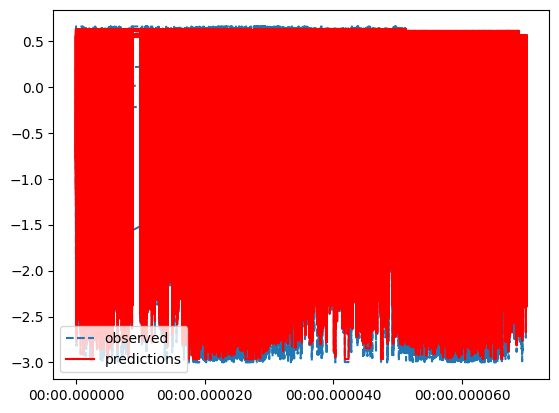

Mean Squared Error: 0.000872039260712572


In [16]:

data = combined_data
data.index = pd.to_datetime(data.index)
data = data.drop('timestamp', axis=1, errors='ignore')

data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day

timeseries = data['value']

train_size = int(len(timeseries) * 0.8)
train, test = timeseries[0:train_size], timeseries[train_size:]

for i in range(1, 6):  
    data[f'lag_{i}'] = timeseries.shift(i)

X = data.drop('value', axis=1)
y = data['value']
X = X[:len(y)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])
predictions = model.predict(X_test)

plt.plot(test.index, y_test, label='observed', linestyle='--')
plt.plot(test.index, predictions, label='predictions', color='red')
plt.legend()
plt.show()

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


# Light-gbm with k-folds 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.285634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3863
[LightGBM] [Info] Number of data points in the train set: 1913719, number of used features: 18
[LightGBM] [Info] Start training from score 0.016364
Fold 1: Mean Squared Error: 0.0007166737643157319


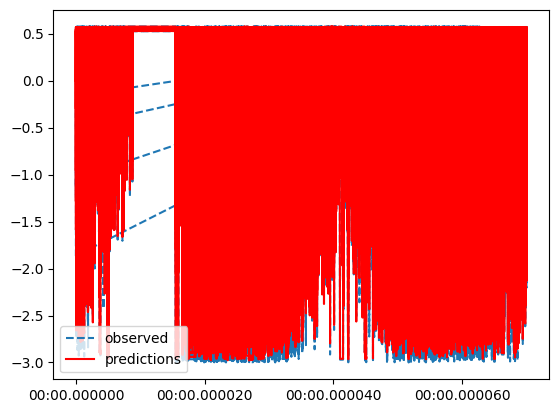

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3862
[LightGBM] [Info] Number of data points in the train set: 1913719, number of used features: 18
[LightGBM] [Info] Start training from score 0.016840
Fold 2: Mean Squared Error: 0.0007905813569336862


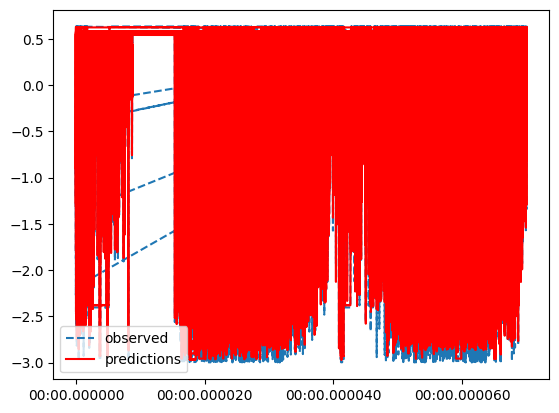

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3866
[LightGBM] [Info] Number of data points in the train set: 1913719, number of used features: 18
[LightGBM] [Info] Start training from score 0.016473
Fold 3: Mean Squared Error: 0.0006881418363063729


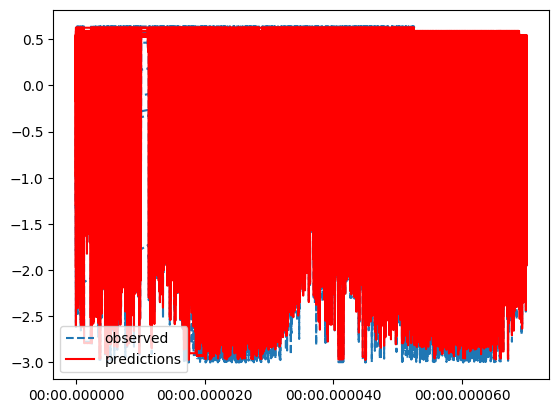

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.434249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3861
[LightGBM] [Info] Number of data points in the train set: 1913719, number of used features: 18
[LightGBM] [Info] Start training from score 0.017541
Fold 4: Mean Squared Error: 0.0006315247238331405


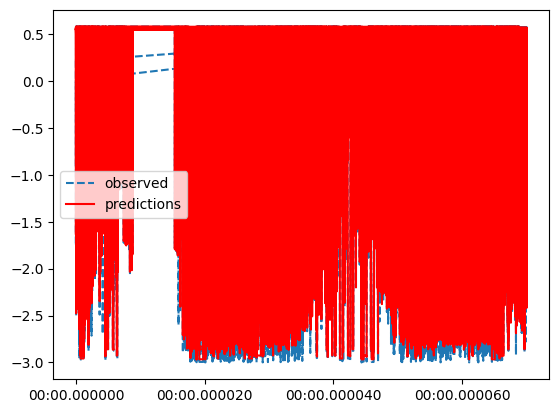

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3854
[LightGBM] [Info] Number of data points in the train set: 1913720, number of used features: 18
[LightGBM] [Info] Start training from score 0.018225
Fold 5: Mean Squared Error: 0.0008720410816867724


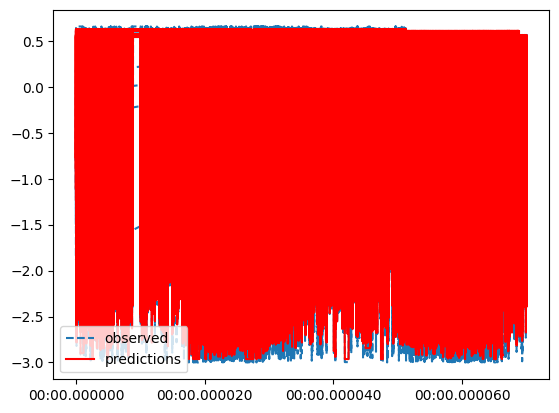

Average Mean Squared Error: 0.0007397925526151409


In [17]:

data = combined_data
data.index = pd.to_datetime(data.index)
data = data.drop('timestamp', axis=1, errors='ignore')

data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day

timeseries = data['value']

# Adding lag features
for i in range(1, 6):  
    data[f'lag_{i}'] = timeseries.shift(i)

X = data.drop('value', axis=1)
y = data['value']
X = X[:len(y)]

n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=False)

mse_scores = []

# Iterate over folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    # Create lgb.Dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train the model
    model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Calculate and store MSE for each fold
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)
    print(f'Fold {i+1}: Mean Squared Error: {mse}')
    # Plot the observed vs. predicted values
    plt.plot(X_test.index, y_test, label='observed', linestyle='--')
    plt.plot(X_test.index, predictions, label='predictions', color='red')
    plt.legend()
    plt.show()

# Calculate and print the average MSE across all folds
average_mse = sum(mse_scores) / n_splits
print(f'Average Mean Squared Error: {average_mse}')


# lightgbm with dataloader 
#### but it actually not like dataloader only runs for one batch 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2851
[LightGBM] [Info] Number of data points in the train set: 1913719, number of used features: 14
[LightGBM] [Info] Start training from score 0.018226


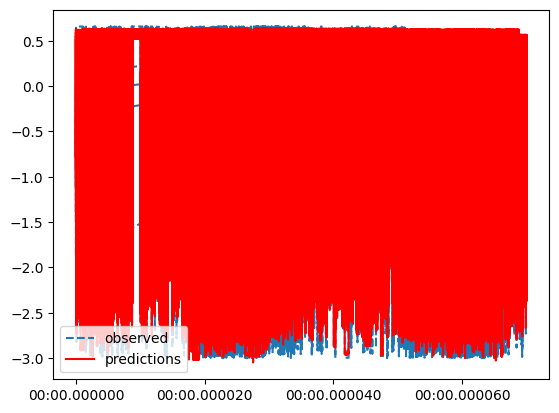

Mean Squared Error: 0.0010404550345745167


In [18]:

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X.iloc[idx].values, self.y.iloc[idx]

data = combined_data.copy()
data['timestamp'] = pd.to_datetime(data['timestamp']).astype('int64') // 10**9


X = data.drop('value', axis=1)
y = data['value']
X = X[:len(y)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_valid])

predictions = model.predict(X_test)

plt.plot(X_test.index, y_test, label='observed', linestyle='--')
plt.plot(X_test.index, predictions, label='predictions', color='red')
plt.legend()
plt.show()

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


### NN model with data loader with single file without preprocessing steps

Epoch [1/2], Batch [1/1752], Loss: 548.7452392578125, Batch MSE: 548.7453002929688
Epoch [1/2], Batch [11/1752], Loss: 169.5796661376953, Batch MSE: 169.5796661376953
Epoch [1/2], Batch [21/1752], Loss: 200.7679901123047, Batch MSE: 200.76797485351562
Epoch [1/2], Batch [31/1752], Loss: 184.9063262939453, Batch MSE: 184.90631103515625
Epoch [1/2], Batch [41/1752], Loss: 270.089111328125, Batch MSE: 270.089111328125
Epoch [1/2], Batch [51/1752], Loss: 45.037750244140625, Batch MSE: 45.037750244140625
Epoch [1/2], Batch [61/1752], Loss: 171.6743927001953, Batch MSE: 171.67440795898438
Epoch [1/2], Batch [71/1752], Loss: 173.21224975585938, Batch MSE: 173.21224975585938
Epoch [1/2], Batch [81/1752], Loss: 69.14286041259766, Batch MSE: 69.14286804199219
Epoch [1/2], Batch [91/1752], Loss: 80.26583099365234, Batch MSE: 80.26583099365234
Epoch [1/2], Batch [101/1752], Loss: 69.18550872802734, Batch MSE: 69.18551635742188
Epoch [1/2], Batch [111/1752], Loss: 16.655115127563477, Batch MSE: 16.

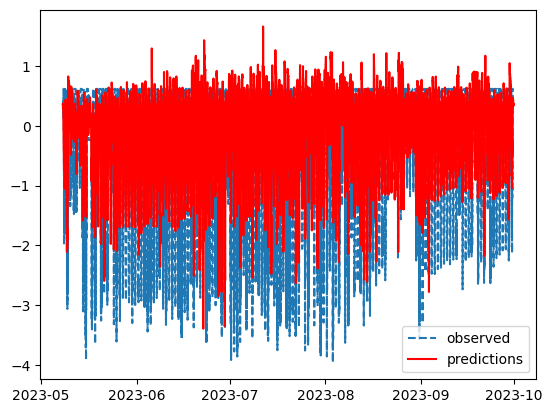

Mean Squared Error: 0.4233200412033969


In [19]:

class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype('float32').replace([np.inf, -np.inf], np.nan).fillna(0) 

        #self.X = X.drop('timestamp', axis=1).astype('float32').replace([np.inf, -np.inf], np.nan).fillna(0) 
        self.y = y.astype('float32').replace([np.inf, -np.inf], np.nan).fillna(0)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X.iloc[idx].values, dtype=torch.float32), torch.tensor(self.y.iloc[idx], dtype=torch.float32)
 
data = pd.read_csv('../Dataset/pv_1.csv', parse_dates=['timestampUtc'], index_col='timestampUtc')

X = data.drop('value', axis=1)
y = data['value']
X = X[:len(y)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = MyModel(input_size=X.shape[1] )

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 2 
print_interval = 10  
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_mse = 0.0

    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        predictions = model(batch_X)

        loss = criterion(predictions.squeeze(), batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_mse = mean_squared_error(batch_y.detach().cpu().numpy(), predictions.detach().cpu().squeeze().numpy())
        running_mse += batch_mse

        if batch_idx % print_interval == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item()}, Batch MSE: {batch_mse}')
       
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    average_mse = running_mse / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}, Average MSE: {average_mse}')

model.eval()
all_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        all_predictions.append(predictions.numpy())

all_predictions = torch.cat([torch.tensor(arr) for arr in all_predictions]).squeeze().numpy()
y_test = pd.Series(y_test).fillna(y_test.mean())

plt.plot(X_test.index, y_test, label='observed', linestyle='--')
plt.plot(X_test.index, all_predictions, label='predictions', color='red')
plt.legend()
plt.show()

mse = mean_squared_error(y_test, all_predictions)
print(f'Mean Squared Error: {mse}')


### NN model with dataloader with preprocessed data set

In [20]:
combined_data_ydm.head

<bound method NDFrame.head of             t_2mc  aswdifd_s  aswdir_s  vmax_10m  tot_prec     value  \
0       -0.610846  -0.736361 -0.502340 -1.109262 -0.122260  0.544067   
1       -0.610846  -0.736361 -0.502340 -1.109262 -0.122260  0.544067   
2       -0.610846  -0.736361 -0.502340 -1.109262 -0.122260  0.544067   
3       -0.610846  -0.736361 -0.502340 -1.109262 -0.122260  0.544067   
4       -0.663283  -0.736361 -0.502340 -1.130614 -0.122260  0.544067   
...           ...        ...       ...       ...       ...       ...   
2392144  0.014525  -0.739053 -0.517767 -0.718850 -0.114433  0.563854   
2392145  0.014525  -0.739053 -0.517767 -0.718850 -0.114433  0.563854   
2392146  0.014525  -0.739053 -0.517767 -0.718850 -0.114433  0.563854   
2392147  0.014525  -0.739053 -0.517767 -0.718850 -0.114433  0.563854   
2392148 -0.130502  -0.739053 -0.517767 -0.850283 -0.114433  0.563854   

         seasonal_trend  seasonal_seasonal  seasonal_residuals  solar_zenith  \
0                   NaN  

## Combined data with year day month columns 

Index(['t_2mc', 'aswdifd_s', 'aswdir_s', 'vmax_10m', 'tot_prec', 'value',
       'seasonal_trend', 'seasonal_seasonal', 'seasonal_residuals',
       'solar_zenith', 'solar_azimuth', 'Day_value_Stamp', 'day_of_week',
       'Holidays', 'year', 'month', 'day'],
      dtype='object')
Epoch [1/2], Batch [1/383],  Batch MSE: 2799.00244140625
Epoch [1/2], Batch [4/383],  Batch MSE: 1079.8411865234375
Epoch [1/2], Batch [7/383],  Batch MSE: 198.64703369140625
Epoch [1/2], Batch [10/383],  Batch MSE: 7.066779136657715
Epoch [1/2], Batch [13/383],  Batch MSE: 168.18045043945312
Epoch [1/2], Batch [16/383],  Batch MSE: 285.91156005859375
Epoch [1/2], Batch [19/383],  Batch MSE: 232.9477996826172
Epoch [1/2], Batch [22/383],  Batch MSE: 101.63666534423828
Epoch [1/2], Batch [25/383],  Batch MSE: 14.691885948181152
Epoch [1/2], Batch [28/383],  Batch MSE: 7.6329522132873535
Epoch [1/2], Batch [31/383],  Batch MSE: 37.62700653076172
Epoch [1/2], Batch [34/383],  Batch MSE: 51.01732635498047
Epoch [

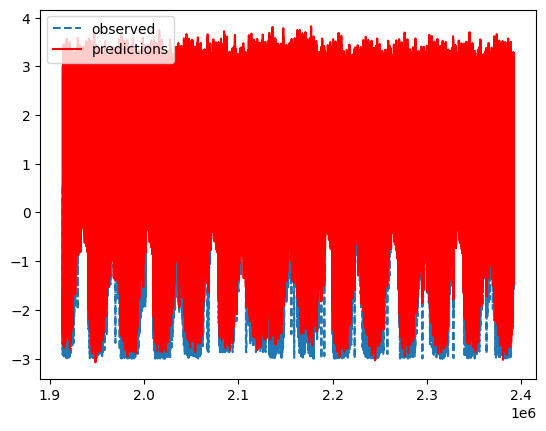

Mean Squared Error: 0.3203947108094613


In [21]:

class MyModel(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype('float32').replace([np.inf, -np.inf], np.nan).fillna(0) 
        self.y = y.astype('float32').replace([np.inf, -np.inf], np.nan).fillna(0)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X.iloc[idx].values, dtype=torch.float32), torch.tensor(self.y.iloc[idx], dtype=torch.float32)
 
data = combined_data_ydm.copy() 

X = data.drop('value', axis=1)
y = data['value']
X = X[:len(y)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False)
 
model = MyModel(input_size=X.shape[1], dropout_rate=0.3 )

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2 
print_interval = 3

best_mse = float('inf')
patience = 10  
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_mse = 0.0

    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        predictions = model(batch_X)

        loss = criterion(predictions.squeeze(), batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_mse = mean_squared_error(batch_y.detach().cpu().numpy(), predictions.detach().cpu().squeeze().numpy())
        running_mse += batch_mse
        running_loss += loss.item()

        if batch_idx % print_interval == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}],  Batch MSE: {batch_mse}')
       

    average_loss = running_loss / len(train_loader)
    average_mse = running_mse / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}, Average MSE: {average_mse}')


    model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            all_predictions.append(predictions.numpy())

        all_predictions = torch.cat([torch.tensor(arr) for arr in all_predictions]).squeeze().numpy()
        y_test = pd.Series(y_test).fillna(y_test.mean())
        mse = mean_squared_error(y_test, all_predictions)

        # Early stopping
        if mse < best_mse:
            best_mse = mse
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1} to prevent overfitting.')
            break

model_save_path = './ModelSaved/model.pth'
os.makedirs('./ModelSaved', exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {model_save_path}')

plt.plot(X_test.index, y_test, label='observed', linestyle='--')
plt.plot(X_test.index, all_predictions, label='predictions', color='red')
plt.legend()
plt.show()

mse = mean_squared_error(y_test, all_predictions)
print(f'Mean Squared Error: {mse}')


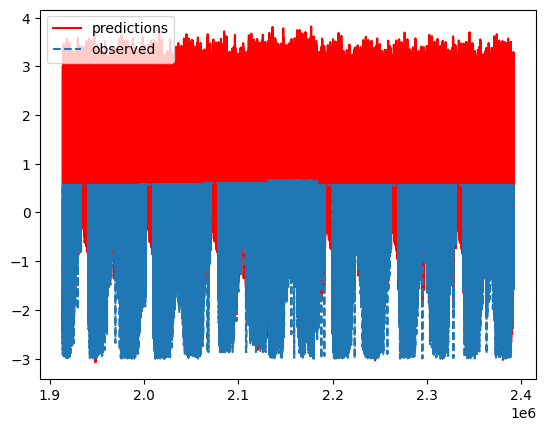

In [22]:
plt.plot(X_test.index, all_predictions, label='predictions', color='red')
plt.plot(X_test.index, y_test, label='observed', linestyle='--')
plt.legend()
plt.show()


In [23]:
X_train.head

<bound method NDFrame.head of             t_2mc  aswdifd_s  aswdir_s  vmax_10m  tot_prec  seasonal_trend  \
0       -0.610846  -0.736361 -0.502340 -1.109262 -0.122260             NaN   
1       -0.610846  -0.736361 -0.502340 -1.109262 -0.122260             NaN   
2       -0.610846  -0.736361 -0.502340 -1.109262 -0.122260             NaN   
3       -0.610846  -0.736361 -0.502340 -1.109262 -0.122260        0.544067   
4       -0.663283  -0.736361 -0.502340 -1.130614 -0.122260        0.544067   
...           ...        ...       ...       ...       ...             ...   
1913714  0.513252   0.493735  1.364068 -0.769598 -0.128028       -0.782674   
1913715  0.866769   0.585406  2.356361 -0.475617 -0.128028       -0.963540   
1913716  0.866769   0.585406  2.356361 -0.475617 -0.128028       -1.137133   
1913717  0.866769   0.585406  2.356361 -0.475617 -0.128028       -1.300599   
1913718  0.866769   0.585406  2.356361 -0.475617 -0.128028       -1.460395   

         seasonal_seasonal  seaso

# Predictions

[-0.2899765 -0.3144478 -0.3344368 ...  2.835916   2.8038573 -0.4892048]


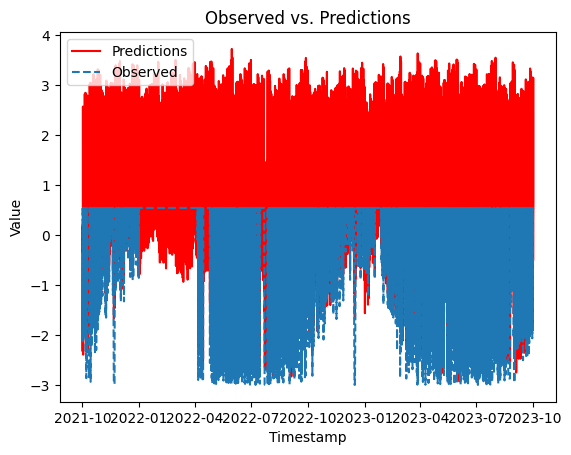

In [24]:

class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_S = X.shape[1]

model_save_path = './ModelSaved/model.pth'
loaded_model = MyModel(input_size=input_S)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()

input_size = X_train.shape[1]
input_data_path = './HolidaysAdded/pv_1.csv'
input_data = pd.read_csv(input_data_path)
input_data_c = input_data

input_data['timestamp'] = pd.to_datetime(input_data['timestamp'])
input_data['year'] = input_data['timestamp'].dt.year
input_data['month'] = input_data['timestamp'].dt.month
input_data['day'] = input_data['timestamp'].dt.day

input_data = input_data.drop('timestamp', axis=1)

input_data_1 = input_data.copy()

input_data.drop(columns=['value'], inplace=True)

input_data = input_data.apply(pd.to_numeric, errors='coerce')

input_data.fillna(0, inplace=True)

if input_data.shape[1] != input_size:
    raise ValueError(f"Input size mismatch. Model expects {input_size} features, but input data has {input_data.shape[1]} features.")

with torch.no_grad():
    input_data_tensor = torch.tensor(input_data.values, dtype=torch.float32)
    input_data_tensor = input_data_tensor.unsqueeze(0)
    prediction = loaded_model(input_data_tensor)

forecast_values = prediction.detach().cpu().numpy().squeeze()
print(forecast_values)

plt.plot(input_data_c['timestamp'], forecast_values, label='Predictions', color='red')
plt.plot(input_data_c['timestamp'], input_data_c['value'], label='Observed', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Observed vs. Predictions')
plt.legend()
plt.show()


# Future Prediction, forecast

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]


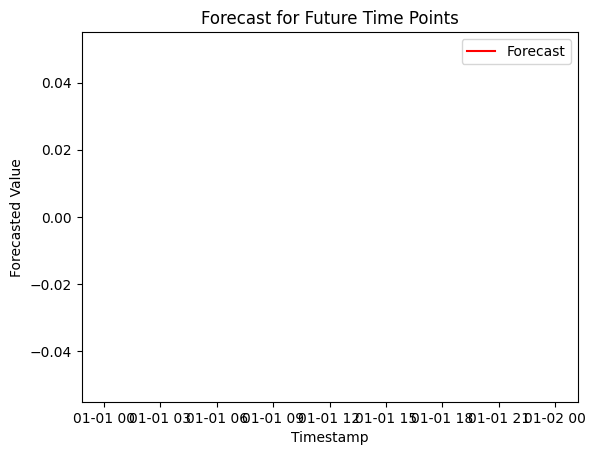

In [30]:
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Load the saved model
model_save_path = './ModelSaved/model.pth'
loaded_model = MyModel(input_size=X.shape[1])
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()

last_timestamp = X_test.index[-1]
forecast_horizon = 30  
future_timestamps = pd.date_range(start=last_timestamp, periods=forecast_horizon + 1, freq='D')[1:]

# Generate synthetic future data (assuming X_test features for simplicity)
future_data = pd.DataFrame(index=future_timestamps, columns=X_test.columns)
future_data = future_data.apply(pd.to_numeric, errors='coerce').astype('float32')

with torch.no_grad():
    future_data_tensor = torch.tensor(future_data.values, dtype=torch.float32)
    future_data_tensor = future_data_tensor.unsqueeze(0)  # Add a batch dimension

    forecast_values = loaded_model(future_data_tensor).detach().cpu().numpy().squeeze()

print(forecast_values)

plt.plot(future_timestamps, forecast_values, label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Forecasted Value')
plt.title('Forecast for Future Time Points')
plt.legend()
plt.show()


In [29]:
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


future_timestamps = pd.date_range(start=input_data_c['timestamp'].max(), periods=10, freq='D')  

future_data = pd.DataFrame({'timestamp': future_timestamps})

future_data['year'] = future_data['timestamp'].dt.year
future_data['month'] = future_data['timestamp'].dt.month
future_data['day'] = future_data['timestamp'].dt.day

future_data = future_data.drop('timestamp', axis=1)

future_data = future_data.apply(pd.to_numeric, errors='coerce')

future_data.fillna(0, inplace=True)

if input_size != future_data.shape[1]:
    raise ValueError(f"Input size mismatch. Model expects {input_size} features, but input data has {future_data.shape[1]} features.")

with torch.no_grad():
    future_data_tensor = torch.tensor(future_data.values, dtype=torch.float32)
    future_data_tensor = future_data_tensor.unsqueeze(0)
    future_predictions = loaded_model(future_data_tensor)

forecast_values = future_predictions.detach().cpu().numpy().squeeze()

print(forecast_values)

plt.plot(input_data_c['timestamp'], input_data_c['value'], label='Observed', linestyle='--')
plt.plot(future_timestamps, forecast_values, label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Observed vs. Forecast')
plt.legend()
plt.show()


ValueError: Input size mismatch. Model expects 16 features, but input data has 3 features.